In [1]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1.Define Test Function

In [2]:
def Testfunction(x):
    dim = len(x)
    y = 0
#     Sphere function
    for i in range(dim):
        y+= x[i]**2
#     Ackley
#     y = 20 + math.e - 20*math.exp(-0.2*(x1**2+x2**2)/2) - math.exp((math.cos(2*3.14*x1)+math.cos(2*3.14*x2))/2)
#     Griewank
#    y = 1 + (x1**2 + x2**2)/400 + math.cos(x1) * math.cos(x2/1.414)
    return y

# 2.Gaussain Process

In [3]:
class GPR(object):
    def __init__(self, optimize=True):
        self.is_fit = False
        self.train_X, self.train_y = None, None
        self.params = {"l": 0.5, "sigma_f": 0.2}

    def fit(self, X, y):
        # store train data
        self.train_X = np.array(X)
        self.train_y = np.array(y)
        self.is_fit = True

    def predict(self, X):
        if not self.is_fit:
            print("GPR Model not fit yet.")
            return 
        X = np.array(X)
        Kff = self.kernel(self.train_X, self.train_X)  # (N, N)
        Kyy = self.kernel(X, X)  # (k, k)
        Kfy = self.kernel(self.train_X, X)  # (N, k)
        Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)
        
        mu = Kfy.T.dot(Kff_inv).dot(self.train_y) #(k,N)*(N,N)*(N*1) = (K*1)
#         print(len(mu))
        cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy) #(K*K - )
#         print(len(cov))
        return mu, cov

    def kernel(self, x1, x2):
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)

# 3. Bayesian Optimization
## 3.1 Inherit from GPR class

In [8]:
class BayesOptimization_GPR(GPR):
    def __init__(self,dim,dbounds,initial_number=5,itera_num=10):
        super(BayesOptimization_GPR, self).__init__()
        self.dim = dim
        self.initial_number = initial_number
        self.testpointperdimnum = 5
        self.kappa=2.576
        self.sigma = 1e-12
        
        self.itera_num = itera_num
        
        self.fitness = []
        
        self.bounds = np.array([item[1] for item in sorted(dbounds.items(), key=lambda x: x[0])],dtype=np.float)
        
    
    def CreatInitialPoint(self,costfunction=None):
        self.train_X = np.ones((self.initial_number,self.dim))
        self.train_Y = np.ones((self.initial_number,1))
        for i in range(self.initial_number):
            for j in range(dim):
                self.train_X[i][j] = np.random.uniform(self.bounds[j][0], self.bounds[j][1])
                
        for i in range(self.initial_number):
            self.train_Y[i] = costfunction(self.train_X[i])

    def PrepareTestPoint(self):
       # bounds = np.array([item[1] for item in sorted(dbounds.items(), key=lambda x: x[0])],dtype=np.float)
        nprr = np.random.RandomState()
        self.test_X = nprr.uniform(self.bounds[:, 0], self.bounds[:, 1],size=(100, self.bounds.shape[0]))

    def Optimize(self,utility_type = "ucb",costfunction=None):
        self.utility_type = utility_type
        self.CreatInitialPoint(costfunction)
        
        for i in range(self.itera_num):
            self.fit(self.train_X, self.train_Y)
            self.PrepareTestPoint()
            mean, cov = self.predict(self.test_X)
            if(self.utility_type == "ucb"):
                util = mean - self.kappa
                prole_item = np.argmin(util)
            elif(self.utility_type == "pi"):
                y_min = np.min(self.train_Y)
                z = (mean - y_min - self.sigma)
                util = 1 - norm.cdf(z)
                probe_item = np.argmin(util)
            elif(self.utility_type == "ei"):
                y_min = np.min(self.train_Y)
                z = (mean - y_min - self.sigma)
                util = (mean - y_min - self.sigma) * norm.cdf(z) + np.diag(cov).reshape(-1,1) * norm.pdf(z)
                probe_item = np.argmin(util)
            x_probe = self.test_X[probe_item]
            y_probe = costfunction(x_probe)
            self.train_X = np.vstack((self.train_X,x_probe))
            self.train_Y = np.vstack((self.train_Y,y_probe))
            self.fitness.append(np.min(self.train_Y))
            print("itera_num = ", i)

itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
itera_num =  10
itera_num =  11
itera_num =  12
itera_num =  13
itera_num =  14
itera_num =  15
itera_num =  16
itera_num =  17
itera_num =  18
itera_num =  19


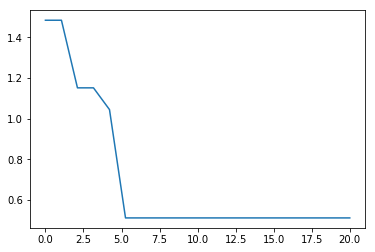

In [5]:
#np.random.seed(0)
# Upper_bound = [3,3,3,3,3,3]
# Lower_bound = [-3,-3,-3,-3,-3,-3]
dbounds = {'x0': (-3, 3), 'x1': (-3, 3), 'x2': (-3, 3), 'x3': (-3, 3), 'x4': (-3, 3)}#, 'x5': (-3, 3)}
# dbounds = {'x0': (-3, 3), 'x1': (-3, 3), 'x2': (-3, 3)}
dim = len(dbounds)

initial_number = 200
itera_num = 20
utility_type = "ei"
Optimizer = BayesOptimization_GPR(dim, dbounds=dbounds, initial_number=initial_number,itera_num=itera_num)
Optimizer.Optimize(utility_type = utility_type, costfunction=Testfunction)
plt.figure(1)
plt.plot(np.linspace(0,itera_num,itera_num),Optimizer.fitness)

## 3.2 Using Gaussian Libaray for Bayesain Optimization
### Notice: for speed up this process, we can choose "return std" for gpr.predict rather "than cov"
### Why Bayesian Optimization Python Package better than this program? 1. using return std rather than return cov 2. using L-BFGS for deeper exploration , which can see in util.py acq_max

In [10]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

class BayesOptimization():
    def __init__(self,dim,dbounds,initial_number=5,itera_num=10):
        self.dim = dim
        self.initial_number = initial_number
        self.testpointperdimnum = 5
        self.kappa=2.576
        self.sigma = 1e-12
        
        self.itera_num = itera_num
        
        self.fitness = []
        
        self.bounds = np.array([item[1] for item in sorted(dbounds.items(), key=lambda x: x[0])],dtype=np.float)
        
        self.kernel = ConstantKernel(constant_value=0.2, constant_value_bounds=(1e-4, 1e4)) * RBF(length_scale=0.5, length_scale_bounds=(1e-4, 1e4))
        self.gpr = GaussianProcessRegressor(kernel=self.kernel, n_restarts_optimizer=2)
        
        self.exploration_gp_num = 5000
    
    def CreatInitialPoint(self,costfunction=None):
        self.train_X = np.ones((self.initial_number,self.dim))
        self.train_Y = np.ones((self.initial_number,1))
        for i in range(self.initial_number):
            for j in range(dim):
                self.train_X[i][j] = np.random.uniform(self.bounds[j][0], self.bounds[j][1])
                
        for i in range(self.initial_number):
            self.train_Y[i] = costfunction(self.train_X[i])

    def PrepareTestPoint(self):
       # bounds = np.array([item[1] for item in sorted(dbounds.items(), key=lambda x: x[0])],dtype=np.float)
        nprr = np.random.RandomState()
        self.test_X = nprr.uniform(self.bounds[:, 0], self.bounds[:, 1],size=(self.exploration_gp_num, self.bounds.shape[0]))

    def Optimize(self,utility_type = "ucb",costfunction=None):
        self.utility_type = utility_type
        self.CreatInitialPoint(costfunction)
        
        for i in range(self.itera_num):
            self.gpr.fit(self.train_X, self.train_Y)
            self.PrepareTestPoint()
            mean, cov = self.gpr.predict(self.test_X, return_cov=True)
#             print(mean.shape)
#             print(cov.shape)
            if(self.utility_type == "ucb"):
                util = mean - self.kappa
                probe_item = np.argmin(util)
            elif(self.utility_type == "pi"):
                y_min = np.min(self.train_Y)
                z = (mean - y_min - self.sigma)
                util = 1 - norm.cdf(z)
                probe_item = np.argmin(util)
            elif(self.utility_type == "ei"):
                y_min = np.min(self.train_Y)
                z = (mean - y_min - self.sigma)
                util = (mean - y_min - self.sigma) * norm.cdf(z) + np.diag(cov).reshape(-1,1) * norm.pdf(z)
                probe_item = np.argmin(util)
#             print(probe_item)
            x_probe = self.test_X[probe_item]
            y_probe = costfunction(x_probe)
            self.train_X = np.vstack((self.train_X,x_probe))
            self.train_Y = np.vstack((self.train_Y,y_probe))
            self.fitness.append(np.min(self.train_Y))
#             print("itera_num = ", i)

itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9


D:\lab\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.81351204e+01,  2.30838545e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 23, 'warnflag': 2}
  " state: %s" % convergence_dict)


itera_num =  10
itera_num =  11
itera_num =  12


D:\lab\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.95041696e+01,  2.58724691e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 22, 'warnflag': 2}
  " state: %s" % convergence_dict)


itera_num =  13
itera_num =  14
itera_num =  15
itera_num =  16
itera_num =  17


D:\lab\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.21092288e+01,  1.78256189e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 19, 'warnflag': 2}
  " state: %s" % convergence_dict)


itera_num =  18


D:\lab\anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.06886387e+01, -1.06375664e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 107, 'nit': 21, 'warnflag': 2}
  " state: %s" % convergence_dict)


itera_num =  19


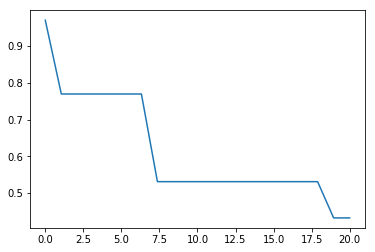

In [85]:
dbounds = {'x0': (-3, 3), 'x1': (-3, 3), 'x2': (-3, 3), 'x3': (-3, 3), 'x4': (-3, 3), 'x5': (-3, 3)}
dim = len(dbounds)

initial_number = 100
itera_num = 20
utility_type = "ucb"
Optimizer = BayesOptimization(dim, dbounds=dbounds, initial_number=initial_number,itera_num=itera_num)
Optimizer.Optimize(utility_type = utility_type, costfunction=Testfunction)
plt.figure(1)
plt.plot(np.linspace(0,itera_num,itera_num),Optimizer.fitness)

# 4.Test Program
## 4.1function Testing

itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
itera_num =  10
itera_num =  11
itera_num =  12
itera_num =  13
itera_num =  14
itera_num =  15
itera_num =  16
itera_num =  17
itera_num =  18
itera_num =  19


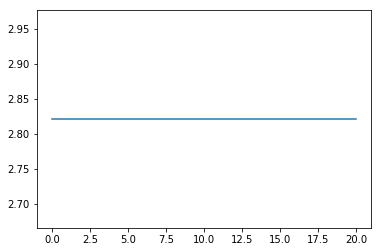

In [9]:
#np.random.seed(0)
# Upper_bound = [3,3,3,3,3,3]
# Lower_bound = [-3,-3,-3,-3,-3,-3]
dbounds = {'x0': (-3, 3), 'x1': (-3, 3), 'x2': (-3, 3), 'x3': (-3, 3), 'x4': (-3, 3), 'x5': (-3, 3)}
# dbounds = {'x0': (-3, 3), 'x1': (-3, 3), 'x2': (-3, 3)}
dim = len(dbounds)

initial_number = 200
itera_num = 20
utility_type = "ei"
Optimizer = BayesOptimization_GPR(dim, dbounds=dbounds, initial_number=initial_number,itera_num=itera_num)
Optimizer.Optimize(utility_type = utility_type, costfunction=Testfunction)
plt.figure(1)
plt.plot(np.linspace(0,itera_num,itera_num),Optimizer.fitness)

## 4.1 EI in defferent dimension（MC simulation）

itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
0 th MC simulation finished
itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
1 th MC simulation finished
itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
2 th MC simulation finished
itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
3 th MC simulation finished
itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
4 th MC simulation finished
itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera

itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
46 th MC simulation finished
itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
47 th MC simulation finished
itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
48 th MC simulation finished
itera_num =  0
itera_num =  1
itera_num =  2
itera_num =  3
itera_num =  4
itera_num =  5
itera_num =  6
itera_num =  7
itera_num =  8
itera_num =  9
49 th MC simulation finished
EI finished


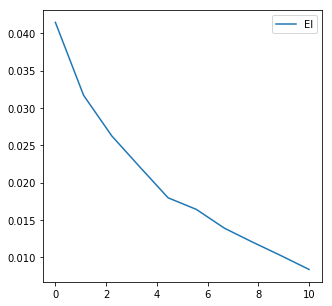

In [11]:
initial_number = 200
itera_num = 10
MC_number = 50

dbounds = {'x0': (-3, 3), 'x1': (-3, 3)}#, 'x2': (-3, 3), 'x3': (-3, 3), 'x4': (-3, 3)}#, 'x5': (-3, 3)}
dim = len(dbounds)

test_process_EI = np.ones((MC_number, itera_num))
utility_type = "ei"

for i in range(MC_number):
    Optimizer = BayesOptimization_GPR(dim, dbounds,initial_number=initial_number,itera_num=itera_num)
    Optimizer.Optimize(utility_type = utility_type, costfunction=Testfunction)
    test_process_EI[i] = Optimizer.fitness
    print(i,"th MC simulation finished")
print("EI finished")

MC_result_EI  = np.sum(test_process_EI, axis=0)/MC_number
plt.figure(2,figsize=(5,5))
plt.plot(np.linspace(0,itera_num,itera_num),MC_result_EI,label="EI")
plt.legend()
plt.show()

In [13]:
print(test_process_EI.shape)
print(MC_result_EI.shape)

(50, 10)
(10,)


## 4.2different AC function simulation（MC simulation）

In [ ]:
MC_number = 50
initial_number = 10
itera_num = 50
MC_number = 50

dbounds = {'x0': (-3, 3), 'x1': (-3, 3), 'x2': (-3, 3), 'x3': (-3, 3), 'x4': (-3, 3), 'x5': (-3, 3)}
dim = len(dbounds)

test_process_EI = np.ones((MC_number, itera_num))
test_process_PI = np.ones((MC_number, itera_num))
test_process_UCB = np.ones((MC_number, itera_num))
utility_type = "ei"

for i in range(MC_number):
    Optimizer = BayesOptimization(dim, dbounds,initial_number=initial_number,itera_num=itera_num)
    Optimizer.Optimize(utility_type = utility_type, costfunction=Testfunction)
    test_process_EI[i] = Optimizer.fitness
print("EI finished")

utility_type = "pi"
for i in range(MC_number):
    Optimizer = BayesOptimization(dim, dbounds,initial_number=initial_number,itera_num=itera_num)
    Optimizer.Optimize(utility_type = utility_type, costfunction=Testfunction)
    test_process_PI[i] = Optimizer.fitness
print("PI finished")
    
utility_type = "ucb"
for i in range(MC_number):
    Optimizer = BayesOptimization(dim, dbounds,initial_number=initial_number,itera_num=itera_num)
    Optimizer.Optimize(utility_type = utility_type, costfunction=Testfunction)
    test_process_UCB[i] = Optimizer.fitness
print("UCB finished")

In [ ]:
MC_result_EI  = np.sum(test_process_EI, axis=0)/MC_number
MC_result_PI  = np.sum(test_process_PI, axis=0)/MC_number
MC_result_UCB = np.sum(test_process_UCB,axis=0)/MC_number
plt.figure(2,figsize=(5,5))
plt.plot(np.linspace(0,itera_num,itera_num),MC_result_EI,label="EI")
plt.plot(np.linspace(0,itera_num,itera_num),MC_result_PI,label="PI")
plt.plot(np.linspace(0,itera_num,itera_num),MC_result_UCB,label="UCB")
plt.legend()
plt.show()

# 5.plot 3D test function graph

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import math
fig = plt.figure(1)
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-8, 8, 0.2)
Y = np.arange(-8, 8, 0.2)
X, Y = np.meshgrid(X, Y)
Z = 20 + math.e - 20*np.exp(-0.2*(X**2+Y**2)/2)- np.exp((np.cos(2*3.14*X) + (np.cos(2*3.14*Y)))/2)
# Z = X**2 + Y**2
# Plot the surface.
ax.plot_surface(X, Y, Z,cmap="rainbow")
plt.show()

In [ ]:
fig = plt.figure(2)
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-8, 8, 0.2)
Y = np.arange(-8, 8, 0.2)
X, Y = np.meshgrid(X, Y)
Z = X**2 + Y**2
# Z = X**2 + Y**2
# Plot the surface.
ax.plot_surface(X, Y, Z,cmap="rainbow")
plt.show()

In [ ]:
fig = plt.figure(3)
ax = fig.gca(projection='3d')
# Make data.
X = np.arange(-8, 8, 0.2)
Y = np.arange(-8, 8, 0.2)
X, Y = np.meshgrid(X, Y)
Z = 1 + (X**2 + Y**2)/400 + np.cos(X)*np.cos(Y/1.414)
print(Z.min())
# Z = X**2 + Y**2
# Plot the surface.
ax.plot_surface(X, Y, Z,cmap="rainbow")
plt.show()

In [ ]:
pbounds = {'x0': (-3, 3), 'x1': (-3, 3), 'x2': (-3, 3), 'x3': (-3, 3), 'x4': (-3, 3), 'x5': (-3, 3)}
bounds = np.array([item[1] for item in sorted(pbounds.items(), key=lambda x: x[0])],dtype=np.float)

print(sorted(pbounds.items(), key=lambda x: x[0]))
print(pbounds.items())
print(bounds)

In [ ]:
x_tries = np.random.RandomState()
a = x_tries.uniform(bounds[:, 0], bounds[:, 1],size=(10000, bounds.shape[0]))
print(a)